### Préparation et nettoyage des données

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.3-py3-none-any.whl size=200466 sha256=6fdb41dc4ec76026f70a25fa8912f31a216afb39fd3a963bedd63375cc7536bb
  Stored in directory: /root/.cache/pip/wheels/2d/60/5b/f74eccd2c9c892a2c298202ca510f10995f9940647fcc2d97f
Successfully built pyod
Initial DataFrame shape: (45672, 16)

Column-wise Missing Values:
 Identifiant               0
date_accident             0
date_communication        0
age                       0
sexe                      0
status_marital           24
enfants                   0
autre_dep                 0
salaire_semaine           0
patrimoine            37346
type_emploi               0
heure_par_semaine         0
jour_par_semaine          0
description               0
cout_init                 0
cout_ultime               0
dtype: int64


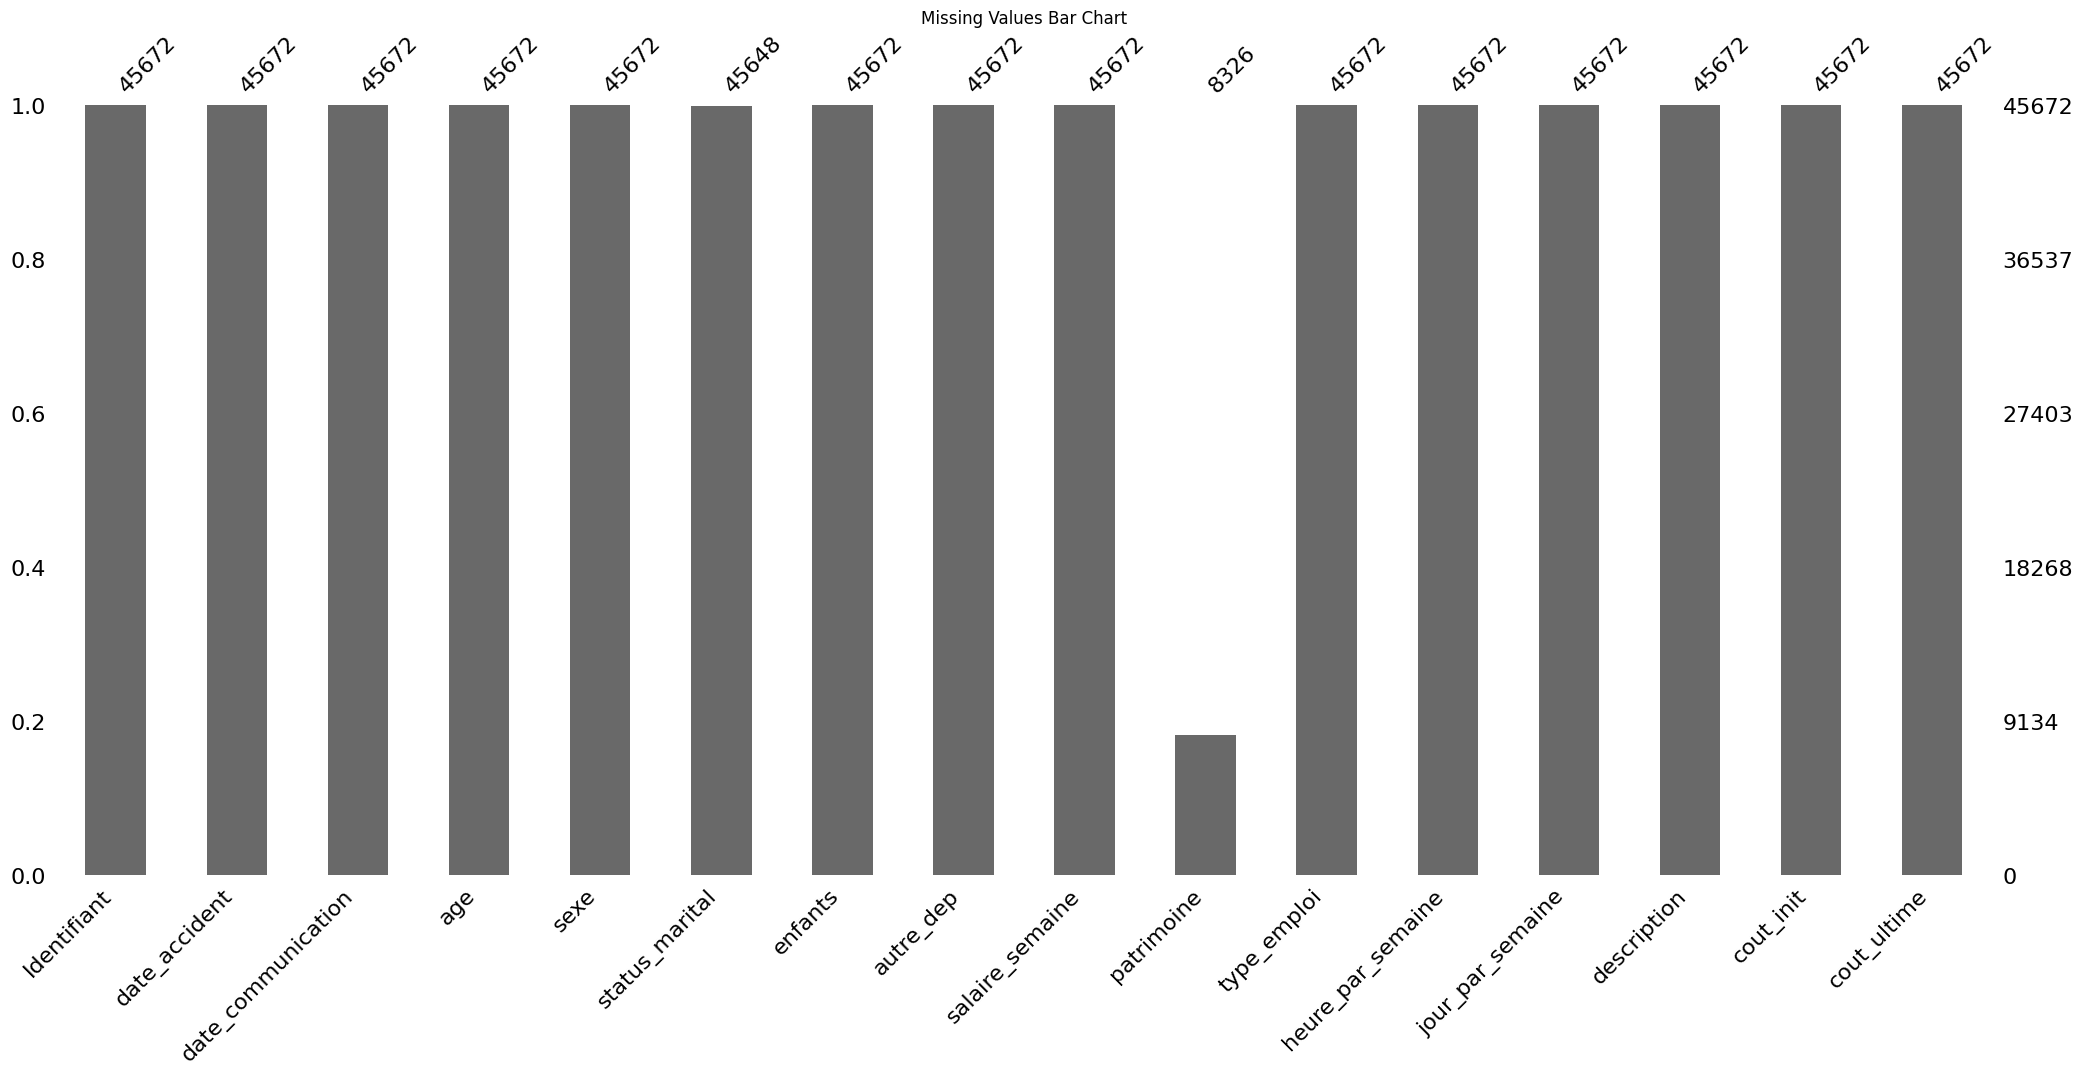

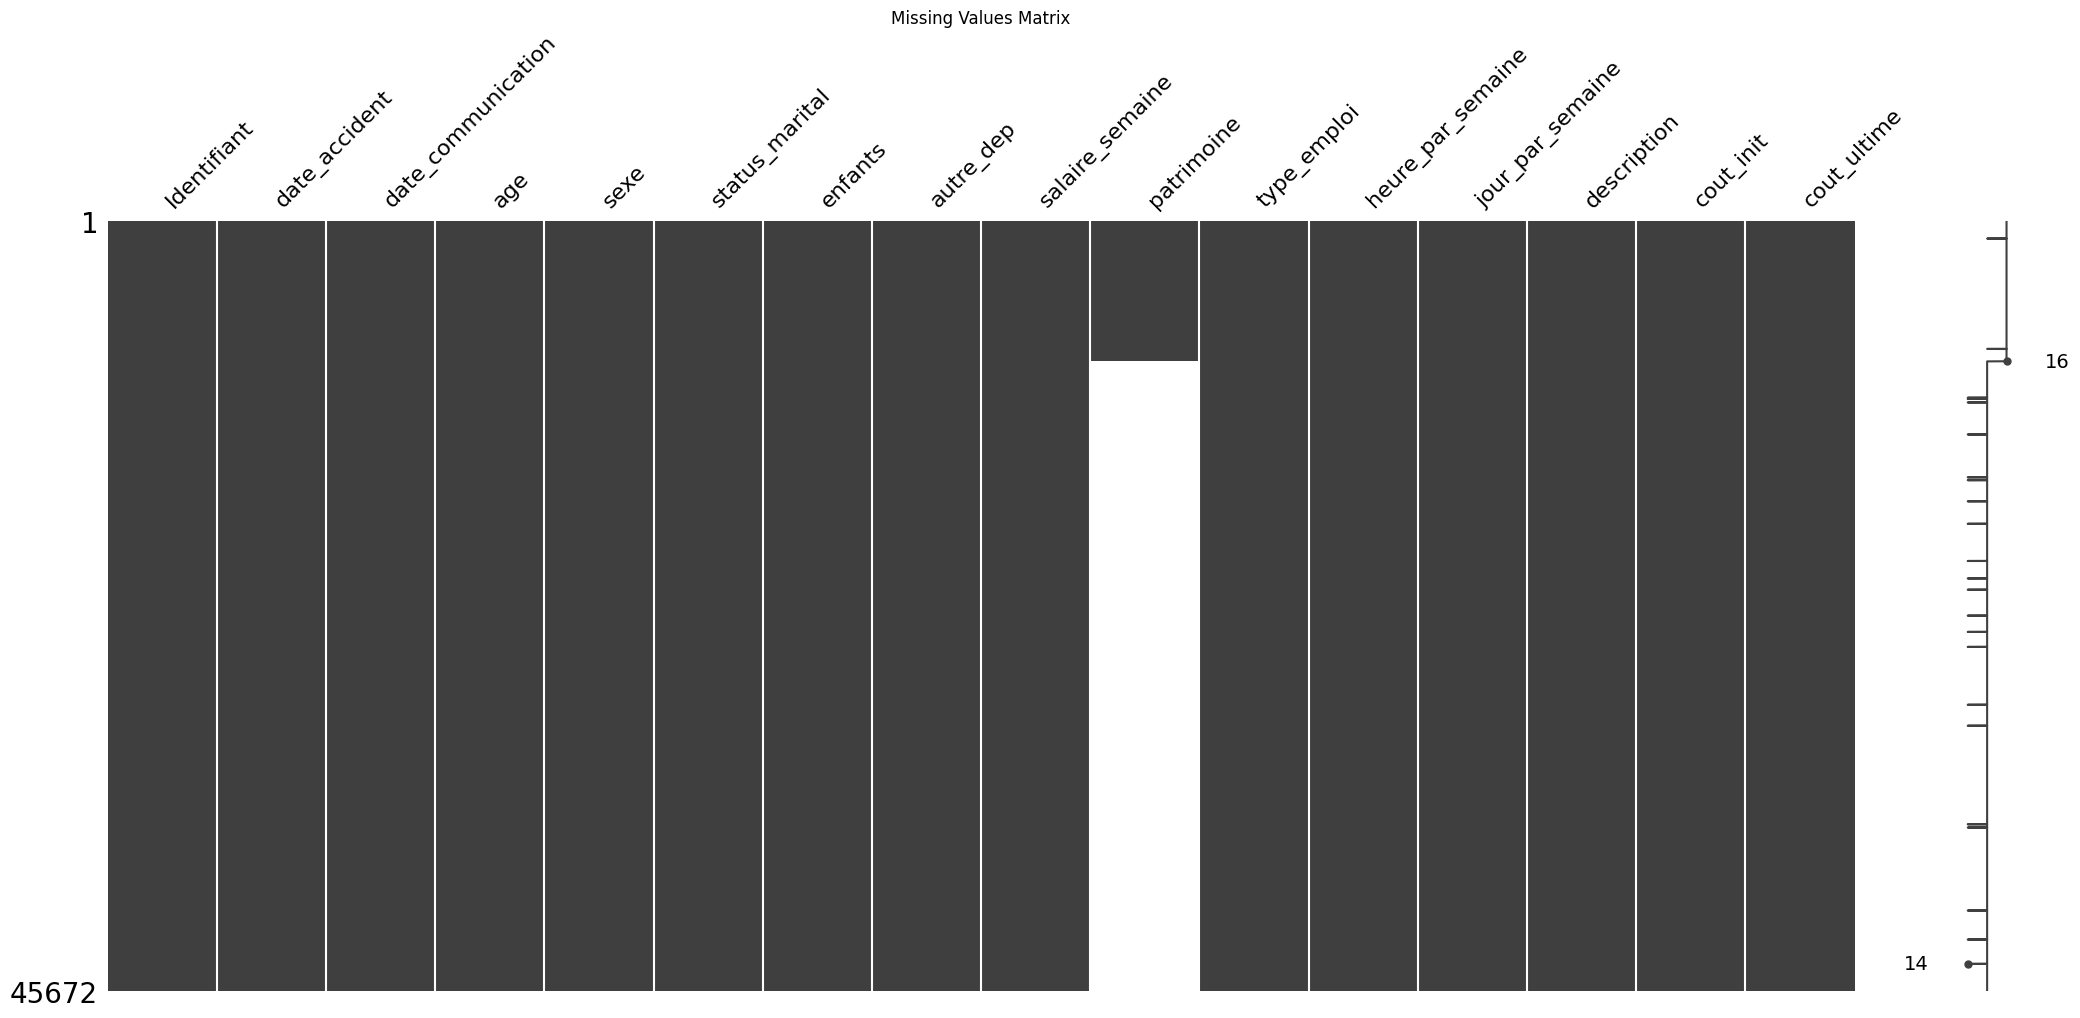

<ipython-input-1-231f7f3a82fa>:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
<ipython-input-1-231f7f3a82fa>:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd


DataFrame shape after missing value imputation: (45672, 16)
Missing Values after imputation:
 Identifiant           0
date_accident         0
date_communication    0
age                   0
sexe                  0
status_marital        0
enfants               0
autre_dep             0
salaire_semaine       0
patrimoine            0
type_emploi           0
heure_par_semaine     0
jour_par_semaine      0
description           0
cout_init             0
cout_ultime           0
dtype: int64

Number of Outliers Detected: 20100
DataFrame shape after outlier removal: (25572, 16)

Number of Outliers Detected by PYOD IForest: 4568


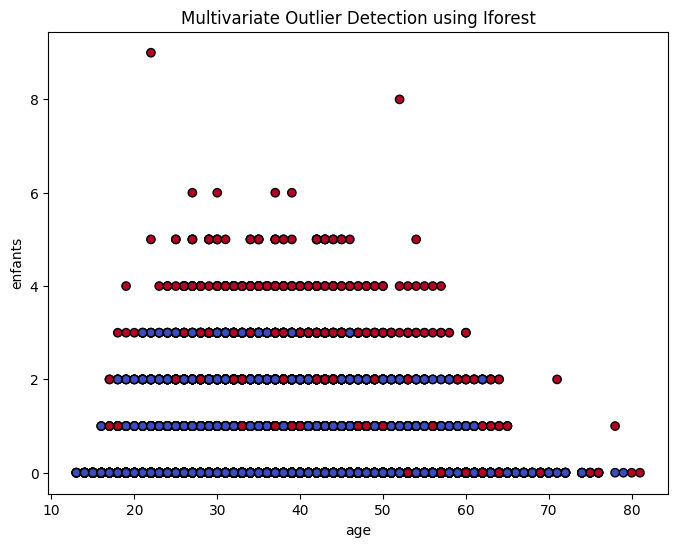

DataFrame shape after outlier removal: (41104, 16)


<Figure size 1200x800 with 0 Axes>

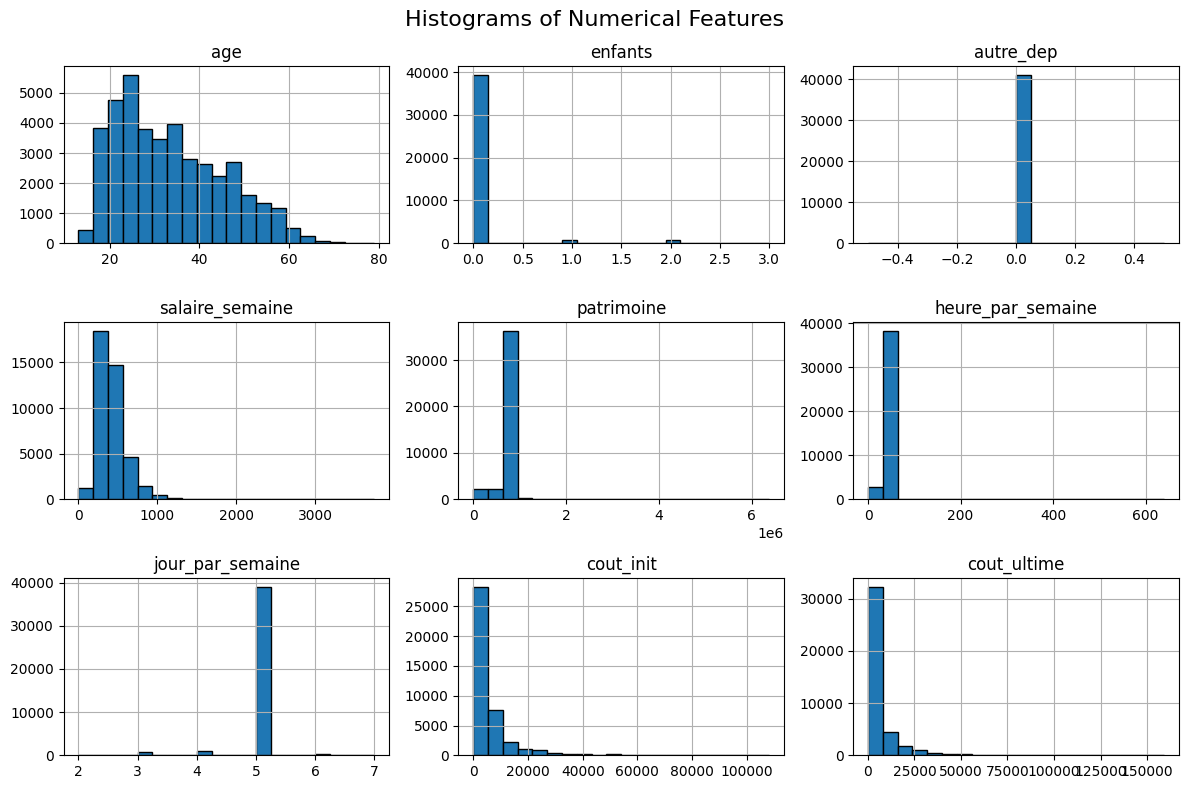

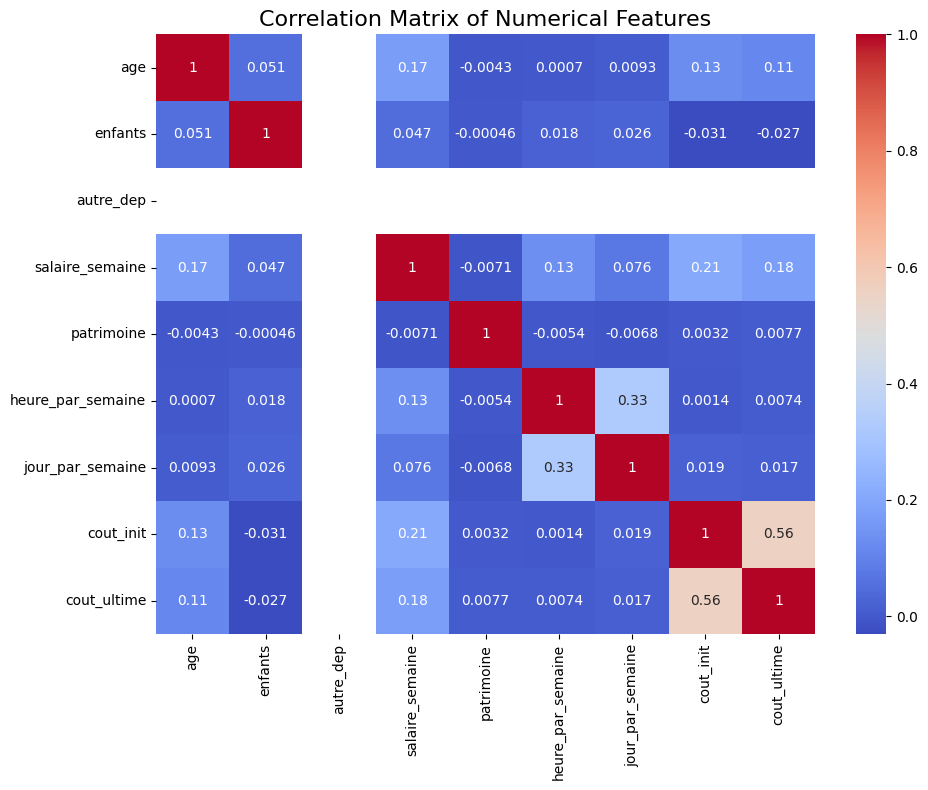

In [1]:
# ÉTAPE PRÉLIMINAIRE : Importation des bibliothèques essentielles à notre analyse

import pandas as pd  # Permet de manipuler les données sous forme de DataFrame
import numpy as np  # Permet les calculs numériques matriciels
import seaborn as sns  # Permet une visualisation avancée des données
import matplotlib.pyplot as plt  # Permet de générer des graphiques simples
from io import StringIO  # Utilisé pour manipuler du texte en mémoire
import plotly.express as px  # Permet une visualisation interactive
import plotly.graph_objects as go  # Permet de générer des graphiques interactifs complexes
from sklearn.model_selection import train_test_split  # Pour séparer des données en jeu d'entraînement et de test
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # Permet l’encodage des variables catégoriques et normalisation
from sklearn.compose import ColumnTransformer  # Permet la transformation des colonnes en pipeline
from sklearn.linear_model import LinearRegression  # Permet d’effectuer des régressions linéaires
from sklearn.tree import DecisionTreeRegressor, plot_tree  # Permet une régression avec arbres de décision
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # Algorithmes d’ensemble pour améliorer la précision et la robustesse des modèles
from sklearn.pipeline import Pipeline  # Permet la création de pipelines de traitement
from sklearn.metrics import mean_squared_error, r2_score  # Permet d’évaluer la qualité des modèles
import statsmodels.api as sm  # Permet une analyse statistique avancée
from sklearn.inspection import partial_dependence, PartialDependenceDisplay  # Permet de visualiser l'effet des variables
import time  # Gestion du temps d'exécution
import missingno as msno  # Pour visualiser des valeurs manquantes

# Importation de la bibliothèque pour la détection et le traitement des anomalies
!pip install pyod  # Exécuter cette commande dans le terminal pour installer la bibliothèque
from pyod.models.iforest import IForest  # Importation du modèle Isolation Forest pour le traitement des données extrêmes
from scipy.stats import probplot  # Pour visualiser des distributions statistiques

# ETAPE 1 : CHARGEMENT ET VISUALISATION DU DATAFRAME

# Chargement du fichier Excel en précisant la feuille de calcul
df = pd.read_excel('/content/train_etu.xlsx')

# Affichage de la taille initiale du DataFrame (nombre de lignes et colonnes)
print("Initial DataFrame shape:", df.shape)

# Affichage du nombre de valeurs manquantes par colonne
print("\nColumn-wise Missing Values:\n", df.isnull().sum())

# VISUALISATION DES DONNÉES MANQUANTES
# Graphe des valeurs manquantes par colonne
msno.bar(df)
plt.title("Missing Values Bar Chart")
plt.show()

# Matrice des valeurs manquantes : permet de voir la distribution des NaN
msno.matrix(df)
plt.title("Missing Values Matrix")
plt.show()

# TRAITEMENT DES DONNÉES MANQUANTES
# Sélection des colonnes numériques
num_cols = df.select_dtypes(include=[np.number]).columns

# Remplacement des valeurs manquantes des colonnes numériques par la moyenne de chaque colonne
for col in num_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mean(), inplace=True)

# Sélection des colonnes catégoriques
cat_cols = df.select_dtypes(include=['object']).columns

# Remplacement des valeurs manquantes des colonnes catégoriques par la valeur la plus fréquente
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

# Affichage de la taille du DataFrame après le traitement des valeurs manquantes
print("\nDataFrame shape after missing value imputation:", df.shape)

# Vérification que toutes les valeurs manquantes ont été traitées
print("Missing Values after imputation:\n", df.isnull().sum())

# ETAPE 2 : DETECTION DES VALEURS ABERRANTES

# Détection des valeurs aberrantes avec la méthode de l'IQR (Interquartile Range)
Q1 = df[num_cols].quantile(0.25)  # Premier quartile
Q3 = df[num_cols].quantile(0.75)  # Troisième quartile
IQR = Q3 - Q1  # Intervalle interquartile

# Détection des valeurs extrêmes en utilisant 1.5 * IQR comme référence
outlier_mask = ((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR)))
outliers_present = outlier_mask.any(axis=1)  # Identification des lignes contenant au moins une valeur aberrante

# Affichage du nombre total de valeurs aberrantes détectées
print("\nNumber of Outliers Detected:", outliers_present.sum())

# Création d'un DataFrame nettoyé sans les valeurs extrêmes
df_clean = df[~outliers_present]
print("DataFrame shape after outlier removal:", df_clean.shape)

# Détection des valeurs aberrantes avec Isolation Forest cette fois
X_numeric = df[num_cols]  # Sélection des colonnes numériques

# Initialisation du modèle IForest avec 10% d’outliers (supposition de valeurs extrêmes)
clf = IForest(contamination=0.1, random_state=42)
clf.fit(X_numeric)  # Entraînement du modèle

# Extraction des labels de valeurs aberrantes (1 = outlier, 0 = normal)
outlier_labels = clf.labels_

# Comptage des outliers détectés par l'Iforest
outliers_present = (outlier_labels == 1)
print("\nNumber of Outliers Detected by PYOD IForest:", outliers_present.sum())

# Visualisation des outliers dans un graphique 2D
if len(num_cols) >= 2:
    plt.figure(figsize=(8, 6))
    plt.scatter(X_numeric[num_cols[0]], X_numeric[num_cols[1]], c=outlier_labels, cmap='coolwarm', edgecolor='k')
    plt.xlabel(num_cols[0])
    plt.ylabel(num_cols[1])
    plt.title("Multivariate Outlier Detection using Iforest")
    plt.show()

# Suppression des outliers détectés
df_clean = df[~outliers_present]
print("DataFrame shape after outlier removal:", df_clean.shape)

# ETAPE 3 : VISUALISATION DES DISTRIBUTIONS DES VARIABLES NUMERIQUES
plt.figure(figsize=(12, 8))
df_clean[num_cols].hist(bins=20, edgecolor='black', figsize=(12, 8))
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# ETAPE 4 : ANALYSE DE CORRELATION ENTRE VARIABLES
plt.figure(figsize=(10, 8))
corr = df_clean[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# ETAPE 5 : VISUALISATION INTERACTIVE AVEC PLOTLY
# Histogramme interactif de l'âge
fig_age = px.histogram(df_clean, x="age", nbins=10, title="Age Distribution (Plotly)")
fig_age.show()

# Matrice de corrélation interactive avec Plotly
fig_corr = go.Figure(data=go.Heatmap(
    z=corr.values,
    x=corr.columns,
    y=corr.columns,
    colorscale='RdBu',
    zmin=-1,
    zmax=1
))
fig_corr.update_layout(title="Correlation Matrix (Plotly)", xaxis_nticks=36)
fig_corr.show()


### Feature engineering

In [2]:
df = df_clean
# Utilisation de la colonne Identifiant comme index
df = df.set_index('Identifiant')

# Suppression des variables patrimoine et autre_dep qui contiennent trop d'erreurs
df.drop(['patrimoine', 'autre_dep'], axis=1, inplace=True)

# Traitement de la variable description à l'aide d'un package d'analyse de texte
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(df['description'])

# Conversion des variables date en format "datetime"
df['date_accident'] = pd.to_datetime(df['date_accident'])
df['date_communication'] = pd.to_datetime(df['date_communication'])

# Encodage des variables catégorielles
df['homme'] = (df['sexe'] == 'M').astype('category')
# df['type_emploi'] = (df['type_emploi'] == 'F').astype('category')
df['date_diff'] = (df['date_communication'] - df['date_accident']).dt.days
# df = pd.get_dummies(df, columns=['status_marital', 'type_emploi'], drop_first=True)
df['log_cout_init'] = np.log(df['cout_init'])
df['date_diff'] = (df['date_communication'] - df['date_accident']).dt.days

# Formes au carré pour les variables age et cout_init, qui présentent le plus de corrélation avec cout_ultime
df['cout_init2'] = df['cout_init']**2
df['age2'] = df['age']**2

# Termes d'interactions pour les variables temporelles
df['salaire_semaine_x_cout_init'] = df['salaire_semaine'] * df['cout_init']
df['hj_par_semaine']=df['heure_par_semaine']*df['jour_par_semaine']
df['heure_par_jour'] = df['heure_par_semaine'] / df['jour_par_semaine']

# Termes d'interactions pour les variables le plus corrélées avec cout_ultime
df['cout_init_par_jour'] = df['cout_init'] / df['jour_par_semaine']
df['age_x_cout_init'] = df['age'] * df['cout_init']

# Ajout de variables supplémentaires pour les dates
df['mois_accident'] = df['date_accident'].dt.month
df['jour_semaine_accident'] = df['date_accident'].dt.weekday  # Lundi=0, Dimanche=6
df['weekend_accident'] = (df['jour_semaine_accident'] >= 5).astype(int)
df['delai_communication'] = (df['date_communication'] - df['date_accident']).dt.days

# Supression de "sexe" car encodé comme variable catégorielle
df.drop(['sexe'], axis=1, inplace=True)

### Préparation pour la régression

In [3]:
# Séparation des variables explicatives et de la variable endogène :
X = df.drop(columns=['cout_ultime','description']) # On supprime la colonne « cout_ultime » et « description »
y = df['cout_ultime'] # On détermine la variable endogène que nous voulons prédire

# Identification des colonnes numériques et catégoriques :
numeric_features = X.select_dtypes(include=np.number).columns.tolist() # On sélectionne uniquement les colonnes contenant des valeurs numériques
categorical_features = X.select_dtypes(include=['object']).columns.tolist() # On sélectionne uniquement les colonnes contenant du texte/catégories

# Prétraitement des données (normalisation et encodage des variables) :
preprocessor = ColumnTransformer(
  transformers=[
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(drop='first'), categorical_features)
  ]) # Normalisation des variables numériques avec StandardScaler (moyenne=0, écart-type=1) et transformation des variables catégoriques avec OneHotEncoder (création de variables binaires), « drop='first' » évite la redondance.

# Division des données en ensemble d'entraînement et de test :
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # On réserve 20 % des données pour le test et on s’assure que la répartition soit la même pour chaque exécution avec « random_state=42 »

# Initialisation des dictionnaires pour stocker les résultats :
results = {} # Dictionnaire pour stocker les scores des modèles (MSE, R²,...)
inference_times = {} # Dictionnaire pour stocker les temps de prédiction/inférence des modèles

### Régresssion linéaire: premier modèle

In [4]:
# Création d'un pipeline pour la régression linéaire :
linear_regression_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), # Transformation des données (normalisation et encodage)
    ('regressor', LinearRegression()) # Modèle de régression linéaire
])

# Entraînement du modèle sur les données d'entraînement :
linear_regression_pipe.fit(X_train, y_train) # Le modèle apprend à prédire « cout_ultime »

# Prédiction sur l'ensemble des données de test et mesure du temps d'exécution :
start_time = time.time() # On démarre le chronomètre
y_pred_lr = linear_regression_pipe.predict(X_test) # Prédictions sur les nouvelles données
end_time = time.time() # On arrête le chronomètre
inference_time_lr = end_time - start_time # On enregistre le temps total de prédiction

# Évaluation du modèle avec RMSE :
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr)) # Calcul de l'erreur quadratique moyenne

# Stockage des résultats et du temps d'inférence :
results["Linear Regression"] = (linear_regression_pipe, rmse_lr, y_pred_lr) # Stocke le modèle entraîné, l'erreur RMSE et les prédictions
inference_times["Linear Regression"] = inference_time_lr # Stocke le temps d'inférence du modèle


### Decision tree regressor

In [5]:
# Création d'un pipeline pour un arbre de décision :
decision_tree_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), # Transformation des données (normalisation et encodage)
    ('regressor', DecisionTreeRegressor(random_state=42)) # Modèle d'arbre de décision
])

# Entraînement du modèle sur les données d'entraînement :
decision_tree_pipe.fit(X_train, y_train)

# Prédiction sur l'ensemble des données de test et mesure du temps d'exécution :
start_time = time.time() # Démarre le chronomètre
y_pred_dt = decision_tree_pipe.predict(X_test) # Prédictions sur les données de test
end_time = time.time() # Arrête le chronomètre
inference_time_dt = end_time - start_time # Enregistre le temps total de prédiction

# Évaluation du modèle avec RMSE :
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt)) # Calcul de l'erreur quadratique moyenne

# Stockage des résultats et du temps d'inférence
results["Decision Tree"] = (decision_tree_pipe, rmse_dt, y_pred_dt) # Stocke le modèle entraîné, l'erreur RMSE et les prédictions
inference_times["Decision Tree"] = inference_time_dt # Stocke le temps d'inférence du modèle


### Random forest

In [6]:
# Création d'un pipeline pour un Random Forest :
random_forest_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), # Prétraitement des données (normalisation et encodage)
    ('regressor', RandomForestRegressor(random_state=42, n_estimators=500)) # Modèle Random Forest avec 500 arbres de décision
])

# Entraînement du modèle sur les données d'entraînement :
random_forest_pipe.fit(X_train, y_train)

# Prédiction sur l'ensemble des données de test et mesure du temps d'exécution :
start_time = time.time() # Démarre le chronomètre
y_pred_rf = random_forest_pipe.predict(X_test) # Prédictions sur les données de test
end_time = time.time() # Arrête le chronomètre
inference_time_rf = end_time - start_time # Enregistre le temps total de prédiction

# Évaluation du modèle avec RMSE :
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf)) # Calcul de l'erreur quadratique moyenne

# Stockage des résultats et du temps d'inférence :
results["Random Forest"] = (random_forest_pipe, rmse_rf, y_pred_rf) # Stocke le modèle entraîné, l'erreur RMSE et les prédictions
inference_times["Random Forest"] = inference_time_rf # Stocke le temps d'inférence du modèle

### Gradient boosting

In [7]:
# Création d'un pipeline pour un Gradient Boosting Regressor :
gradient_boosting_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), # Transformation des données (normalisation et encodage)
    ('regressor', GradientBoostingRegressor(random_state=42, n_estimators=500)) # Modèle Gradient Boosting avec 500 arbres
])

# Entraînement du modèle sur les données d'entraînement :
gradient_boosting_pipe.fit(X_train, y_train)

# Prédiction sur l'ensemble des données de test et mesure du temps d'exécution :
start_time = time.time() # Démarre le chronomètre
y_pred_gb = gradient_boosting_pipe.predict(X_test) # Prédictions sur les données de test
end_time = time.time() # Arrête le chronomètre
inference_time_gb = end_time - start_time # Enregistre le temps total de prédiction

# Évaluation du modèle avec RMSE :
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))

# Stockage des résultats et du temps d'inférence :
results["Gradient Boosting"] = (gradient_boosting_pipe, rmse_gb, y_pred_gb) # Stocke le modèle entraîné, l'erreur RMSE et les prédictions
inference_times["Gradient Boosting"] = inference_time_gb # Stocke le temps d'inférence du modèle

### Mesures d'erreurs utilisées

Pour évaluer la performance de nos différents modèles de régression linéaire, nous utiliserons deux mesures d’erreur complémentaires : le Root Mean Squared Error (RMSE) et le coefficient de détermination (R²).

Le RMSE est une mesure couramment utilisée qui évalue l’écart-type des résidus, c’est-à-dire la différence entre les valeurs prédites et les valeurs réelles. Il est particulièrement utile car il conserve les mêmes unités que la variable cible, ce qui facilite l’interprétation des erreurs du modèle. Plus le RMSE est faible, plus le modèle est précis dans ses prédictions.

Le R², quant à lui, indique la proportion de la variance de la variable cible expliquée par le modèle. Il permet d’évaluer dans quelle mesure le modèle parvient à capturer la relation entre les variables explicatives et la variable cible. Un R² proche de 1 signifie que le modèle explique bien les variations des données, tandis qu’un R² faible indique une mauvaise capacité prédictive.

En combinant ces deux métriques, nous pourrons obtenir une vision plus complète de la qualité de nos modèles : le RMSE nous renseigne sur l’ampleur des erreurs de prédiction, tandis que le R² nous indique dans quelle mesure le modèle est globalement efficace pour expliquer les variations des données.

### Comparatif des modèles

In [8]:
# Affichage des performances des modèles :
print("\nModel Performance (RMSE):")

# Boucle pour parcourir tous les modèles stockés dans "results"
for model_name, (pipe, rmse, y_pred) in results.items():
    print(f"{model_name}: RMSE = {rmse:.2f}, Inference time = [{inference_times[model_name]:.2f}s]") # Affichage des résultats de chaque modèle


Model Performance (RMSE):
Linear Regression: RMSE = 10268.72, Inference time = [0.04s]
Decision Tree: RMSE = 16422.97, Inference time = [0.02s]
Random Forest: RMSE = 10699.67, Inference time = [1.24s]
Gradient Boosting: RMSE = 10261.87, Inference time = [0.04s]


### Classement des modèles

D'après l'analyse des performances des modèles, nous pouvons comparer trois approches différentes : la régression linéaire, l'arbre de décision et le gradient boosting.

Tout d'abord, la régression linéaire obtient un RMSE de 10 268,72, ce qui signifie que ses prédictions ont une marge d'erreur moyenne relativement faible. Son coefficient de détermination
𝑅 carré
  est de 0,5313, indiquant qu'il explique environ 53,13 % de la variance des données. Ce modèle est intéressant car il est simple, rapide et facilement interprétable.

Ensuite, l'arbre de décision montre des performances nettement inférieures. Son RMSE de 16 422,97 est le plus élevé des trois modèles, ce qui signifie que ses prédictions sont les moins précises. De plus, son
𝑅 carré
  est négatif (-0,1987), ce qui suggère qu'il est pire qu'un modèle qui prédirait simplement la moyenne des données. Cela peut indiquer un surajustement ou un mauvais choix d'hyperparamètres.

Enfin, le gradient boosting offre les meilleurs résultats avec un RMSE de 10 261,87, légèrement inférieur à celui de la régression linéaire. Son
𝑅 carré
  de 0,5320 est aussi le plus élevé, ce qui signifie qu'il explique légèrement mieux la variance des données. Bien que son temps d'inférence soit un peu plus long, ce modèle constitue le meilleur choix en termes de précision.



### Conclusion

En conclusion, le gradient boosting est le modèle le plus performant et devrait être privilégié si l’objectif est d’obtenir les prédictions les plus précises possibles. Toutefois, si l’interprétabilité et la simplicité sont prioritaires, la régression linéaire reste une alternative intéressante. L’arbre de décision, en revanche, semble inadapté dans sa forme actuelle et nécessiterait des ajustements pour améliorer ses performances.